In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [115]:
# plt.style.use('seaborn-v0_8-muted')
plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-ticks')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  


In [116]:
# Import dataset
data = pd.read_csv('all_semeval_parids-labels.csv')

# Class distributions

In [117]:
# Plot the distribution of orig_label, with the x-axis values in ascending order
plt.figure(figsize=(6, 3.5))
orig_label_counts = data['orig_label'].value_counts()

orig_label_counts.sort_index().plot(kind='bar')
plt.ylabel('Number of instances')
plt.xlabel('Original label')

# Grid
plt.grid(True, which='major', linestyle='--', linewidth=0.5)


# Text Lengths

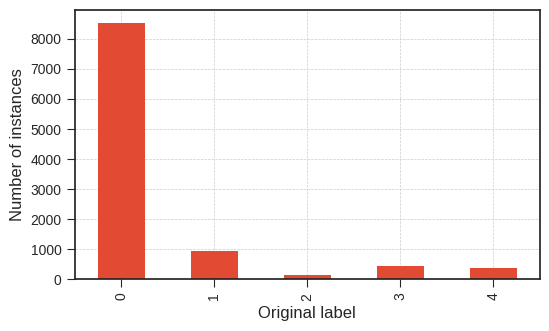

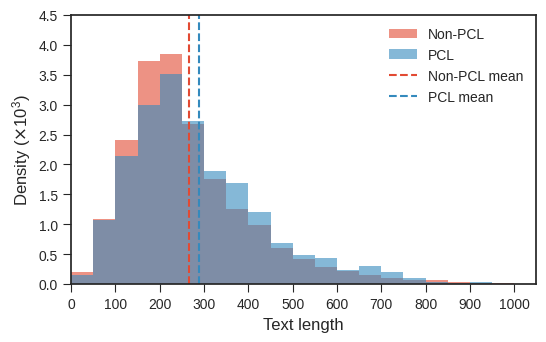

In [118]:
# Get the text lengths for each class
pcl_lengths = data[data['label'] == 1]['text'].str.len()
non_pcl_lengths = data[data['label'] == 0]['text'].str.len()

# Last bin captures all 1000+
bin_edges = [i for i in range(0, 1001, 50)] + [int(max(np.max(pcl_lengths), np.max(non_pcl_lengths))) + 1]

# Plot histogram
plt.figure(figsize=(6, 3.5))
plt.hist([non_pcl_lengths], bins=bin_edges, width=50, density=True, alpha=0.6, label=['Non-PCL'])
plt.hist([pcl_lengths], bins=bin_edges, width=50, density=True, alpha=0.6, label=['PCL'])

# Labels and legend
# x_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1]-1)}" for i in range(len(bin_edges)-2)] + ["1000+"]
# x_labels = [int(bin_edges[i]) for i in range(1, len(bin_edges)-1)] + ["1000+"]
plt.xticks(ticks=[(100 * i) for i in range(len(bin_edges) // 2)], rotation=0)
plt.xlabel("Text length")
plt.xlim(0, 1049)
plt.yticks(ticks=plt.yticks()[0][:], labels=(1000 * np.array(plt.yticks()[0][:], dtype=np.float64)).round(1))
plt.ylabel(r"Density ($\times\mathregular{10^3}$)")
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot the means for each class
plt.axvline(x=np.mean(non_pcl_lengths), color=colors[0], linestyle='--', label='Non-PCL mean')
plt.axvline(x=np.mean(pcl_lengths), color=colors[1], linestyle='--', label='PCL mean')
plt.legend()

# Show plot
plt.show()

# Stopword ratio

In [119]:
import pandas as pd
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

def compute_stopword_ratio(df, text_col="text", label_col="label"):
    stop_words = set(stopwords.words('english'))
    
    def stopword_ratio(text):
        words = text.split()
        return sum(1 for word in words if word.lower() in stop_words) / len(words) if words else 0

    df["stopword_ratio"] = df[text_col].apply(stopword_ratio)
    return df.groupby(label_col)["stopword_ratio"].describe()

pcl_data = data[data['label'] == 1]
non_pcl_data = data[data['label'] == 0]

# Replace Nan with empty string
pcl_nan_idx = pcl_data[pcl_data['text'].isna()].index
non_pcl_nan_idx = non_pcl_data[non_pcl_data['text'].isna()].index
pcl_data.loc[pcl_nan_idx, 'text'] = ''
non_pcl_data.loc[non_pcl_nan_idx, 'text'] = ''

pcl_stopword_ratio = compute_stopword_ratio(pcl_data)
non_pcl_stopword_ratio = compute_stopword_ratio(non_pcl_data)

print("PCL stopword ratio:")
print(pcl_stopword_ratio)
print("\nNon-PCL stopword ratio:")
print(non_pcl_stopword_ratio)

PCL stopword ratio:
       count      mean       std  min      25%  50%       75%  max
label                                                             
1      993.0  0.395134  0.078369  0.0  0.34375  0.4  0.447368  0.6

Non-PCL stopword ratio:
        count      mean       std  min       25%       50%       75%       max
label                                                                         
0      9476.0  0.366499  0.081662  0.0  0.315789  0.368421  0.420739  0.645161


[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipykernel_724769/2368421877.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stopword_ratio"] = df[text_col].apply(stopword_ratio)
/tmp/ipykernel_724769/2368421877.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["stopword_ratio"] = df[text_col].apply(stopword_ratio)


# Type-Token Ratio (TTR): vocab diversity

In [120]:
def compute_ttr(df, text_col="text", label_col="label"):
    def ttr(text):
        words = text.split()
        return len(set(words)) / len(words) if words else 0

    df["ttr"] = df[text_col].apply(ttr)
    return df.groupby(label_col)["ttr"].describe()

pcl_ttr = compute_ttr(pcl_data)
non_pcl_ttr = compute_ttr(non_pcl_data)

print("PCL TTR:")
print(pcl_ttr)
print("\nNon-PCL TTR:")
print(non_pcl_ttr)


/tmp/ipykernel_724769/409726575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ttr"] = df[text_col].apply(ttr)


PCL TTR:
       count      mean       std       min      25%       50%       75%  max
label                                                                       
1      993.0  0.826818  0.096115  0.451977  0.76087  0.827586  0.897436  1.0

Non-PCL TTR:
        count      mean    std  min       25%   50%       75%  max
label                                                             
0      9476.0  0.845608  0.092  0.0  0.783784  0.85  0.913043  1.0


/tmp/ipykernel_724769/409726575.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ttr"] = df[text_col].apply(ttr)


# Common phrases

In [121]:
from collections import defaultdict
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import gc

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def compute_ngrams(df, text_col="text", label_col="label", n=2, top_n=10, remove_stopwords=True, batch_size=5000):
    """
    Computes the most frequent n-grams (bigrams/trigrams) per class while merging duplicates.
    """

    def preprocess_text(text):
        """ Removes stopwords if enabled """
        words = text.split()
        if remove_stopwords:
            words = [word.lower() for word in words if word.lower() not in stop_words]  # Lowercasing for consistency
        return " ".join(words)

    results = {}

    for label in df[label_col].unique():
        texts = df[df[label_col] == label][text_col]

        if remove_stopwords:
            texts = texts.apply(preprocess_text)

        vectorizer = CountVectorizer(ngram_range=(n, n))
        ngram_counts = defaultdict(int)  # Dictionary to store aggregated n-gram counts

        for chunk in range(0, len(texts), batch_size):
            text_chunk = texts.iloc[chunk:chunk+batch_size]
            X = vectorizer.fit_transform(text_chunk)
            freqs = X.sum(axis=0).A1
            vocab = vectorizer.get_feature_names_out()
            
            # Merge duplicate n-grams
            for ngram, count in zip(vocab, freqs):
                ngram_counts[ngram] += count  # Aggregate counts

        # Sort and keep only top-N results
        sorted_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
        results[label] = sorted_ngrams

        # Free up memory
        gc.collect()

    return results

# Replace NaNs in the original data with empty strings
nan_idx = data[data['text'].isna()].index
data.loc[nan_idx, 'text'] = ''

# Compute bigrams and trigrams
pcl_bigrams = compute_ngrams(pcl_data, n=2)
non_pcl_bigrams = compute_ngrams(non_pcl_data, n=2)
pcl_trigrams = compute_ngrams(pcl_data, n=3)
non_pcl_trigrams = compute_ngrams(non_pcl_data, n=3)


[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [122]:
# Pretty print the results, dividing each frequency by the total number of instances in the class
def pretty_print_ngrams(ngrams, total_instances):
    for label, ngram_list in ngrams.items():
        print(f"{label} n-grams:")
        for ngram, count in ngram_list:
            print(f"{ngram}: {count / total_instances[label]:.4f}")
        print()

total_instances = data['label'].value_counts()

print("PCL bigrams:")
pretty_print_ngrams(pcl_bigrams, total_instances)
print("Non-PCL bigrams:")
pretty_print_ngrams(non_pcl_bigrams, total_instances)

PCL bigrams:
1 n-grams:
poor families: 0.1511
people need: 0.0292
homeless people: 0.0262
children poor: 0.0211
help need: 0.0181
disabled people: 0.0141
men women: 0.0121
vulnerable people: 0.0121
help people: 0.0111
let us: 0.0111

Non-PCL bigrams:
0 n-grams:
poor families: 0.0814
illegal immigrants: 0.0321
per cent: 0.0169
united states: 0.0163
last year: 0.0129
year old: 0.0128
homeless people: 0.0116
disabled people: 0.0112
new york: 0.0106
sri lanka: 0.0106



# Hyperparameter tuning

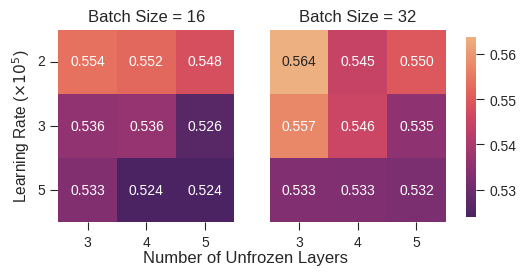

In [168]:
import seaborn as sns

# Load data into DataFrame
df = pd.read_csv('gridsearch.csv')

# Split data by batch size
df_16 = df[df['batch_size'] == 16].pivot_table(index='lr', columns='num_layers_unfrozen', values='average_f1_score')
df_32 = df[df['batch_size'] == 32].pivot_table(index='lr', columns='num_layers_unfrozen', values='average_f1_score')

# Set colorbar limits
vmin = min(df['average_f1_score'])
vmax = max(df['average_f1_score'])

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.94, 0.13, 0.02, 0.72])  # Adjust colorbar height to match heatmaps

cmap = sns.color_palette("flare_r", as_cmap=True)

# Plot heatmaps without individual colorbars
sns.heatmap(df_16, annot=True, fmt='.3f', cmap=cmap, linewidths=0, vmin=vmin, vmax=vmax, ax=axes[0], cbar=False)
axes[0].set_title("Batch Size = 16", fontsize=12)
axes[0].set_xlabel("")
axes[0].set_ylabel(f"Learning Rate ({r'$\times 10^5$'})", fontsize=11.2)

sns.heatmap(df_32, annot=True, fmt='.3f', cmap=cmap, linewidths=0, vmin=vmin, vmax=vmax, ax=axes[1], cbar=True, cbar_ax=cbar_ax)
axes[1].set_title("Batch Size = 32", fontsize=12)
axes[1].set_xlabel("")
axes[1].set_ylabel("")  # Remove y-axis label for better alignment
axes[1].tick_params(left=False)  # Remove only left tick marks

axes[0].set_yticklabels([f'{float(label.get_text()) * 1e5:.0f}' for label in axes[0].get_yticklabels()], rotation=0)

# Add a shared xlabel
fig.text(0.5, -0.05, "Number of Unfrozen Layers", ha='center', fontsize=12)

# Adjust layout and save
# plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
plt.show()